In [142]:
import os, gc
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install category_encoders
from category_encoders import TargetEncoder

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedGroupKFold, train_test_split, TimeSeriesSplit

from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error, mean_squared_error



#### Read Files

In [2]:
building = pd.read_csv('../data/building_metadata.csv')
weather_train = pd.read_csv('../data/weather_train.csv')
weather_test = pd.read_csv('../data/weather_test.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

#### Missing Data

In [166]:
#Missing Data Percentage
1 - train.count()/ len(train)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [167]:
#Missing Data Percentage
1 - weather_train.count()/ len(weather_train)

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [168]:
#Missing Data Percentage
1 - building.count()/ len(building)

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

#### Helper Functions for Data Processing

##### `optimize_df_mem_usage` - Reduce dataframe memory usage by using smaller datatypes
##### `weather_data_parser` - Fill in the missing data values for weather dataframe

In [4]:
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
def optimize_df_mem_usage(data, use_float16=True):
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in data.columns:
        if is_datetime(data[col]) or is_categorical_dtype(data[col]):
            continue
        col_type = data[col].dtype
        
        if col_type in [np.dtype('<M8[ns]'), np.dtype('>M8[ns]'), np.dtype('datetime64')]:
            continue
        elif col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.2f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return data

In [3]:
def weather_data_parser(weather_data):
    time_format = '%Y-%m-%d %H:%M:%S'
    start_date = datetime.datetime.strptime(weather_data['timestamp'].min(), time_format)
    end_date = datetime.datetime.strptime(weather_data['timestamp'].max(), time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    for site_id in range(16):
        site_hours = np.array(weather_data[weather_data['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list, site_hours), columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_data = pd.concat([weather_data, new_rows], sort=True)
        weather_data = weather_data.reset_index(drop=True)           

    weather_data['datetime'] = pd.to_datetime(weather_data['timestamp'])
    weather_data['day'] = weather_data['datetime'].dt.day
    weather_data['week'] = weather_data['datetime'].dt.isocalendar().week
    weather_data['month'] = weather_data['datetime'].dt.month

    weather_data = weather_data.set_index(['site_id', 'day', 'month'])

    air_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['air_temperature'].median(), columns=['air_temperature'])
    weather_data.update(air_temperature_filler, overwrite=False)

    cloud_coverage_filler = weather_data.groupby(['site_id', 'day', 'month'])['cloud_coverage'].median()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'), columns=['cloud_coverage'])

    weather_data.update(cloud_coverage_filler, overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['dew_temperature'].median(), columns=['dew_temperature'])
    weather_data.update(due_temperature_filler, overwrite=False)

    sea_level_filler = weather_data.groupby(['site_id','day','month'])['sea_level_pressure'].median()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'), columns=['sea_level_pressure'])

    weather_data.update(sea_level_filler, overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_direction'].median(), columns=['wind_direction'])
    weather_data.update(wind_direction_filler, overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_speed'].median(), columns=['wind_speed'])
    weather_data.update(wind_speed_filler, overwrite=False)

    precip_depth_filler = weather_data.groupby(['site_id','day','month'])['precip_depth_1_hr'].median()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'), columns=['precip_depth_1_hr'])

    weather_data.update(precip_depth_filler, overwrite=False)

    weather_data = weather_data.reset_index()
    weather_data = weather_data.drop(['datetime','day','week','month'], axis=1)

    return weather_data

In [5]:
# Pre-process the weather dataset
weather_train = weather_data_parser(weather_train)

In [6]:
# Convert timestamp to datetime
train["timestamp"] = pd.to_datetime(train["timestamp"])
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"])

In [7]:
# Optimize the dataframe memory usage
train = optimize_df_mem_usage(train)
weather_train = optimize_df_mem_usage(weather_train)
building = optimize_df_mem_usage(building)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.12%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 3.08 MB
Decreased by 68.05%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.88%


#### Boxplot of the meter_readings for meter_type (to check for outliers)

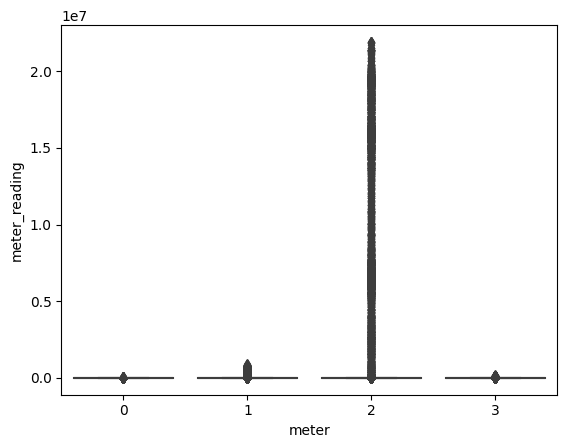

In [226]:
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=True);

### For meter 0, there's a significant number of zeros. Investigating the number of zeros for meter 0

45594

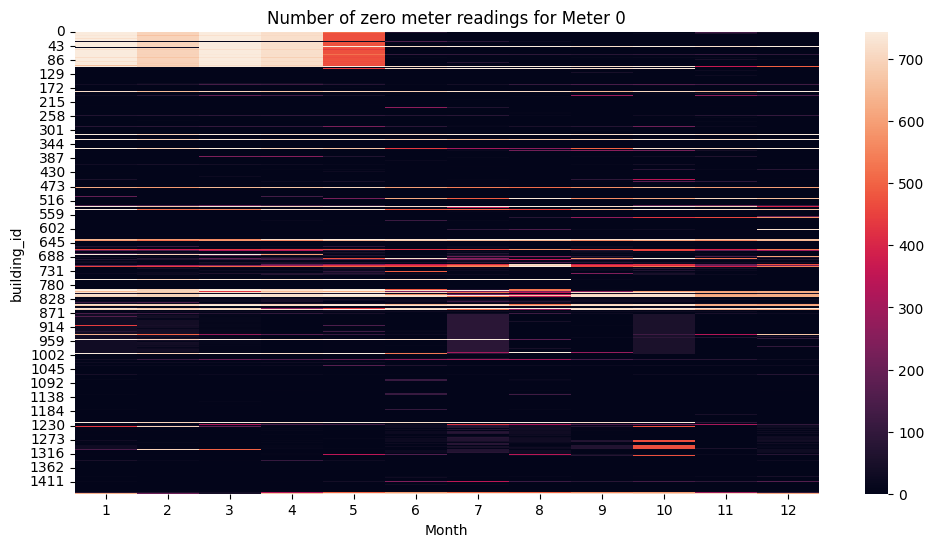

In [200]:
temp = train.copy()
temp["Month"] = temp["timestamp"].dt.month
temp = temp[temp["meter"]==0]
temp["zero_meter_reading"] = (temp["meter_reading"] < 5).astype(int)
temp = temp.groupby(["building_id","Month"]).agg(sum_zero_counts = ("zero_meter_reading", "sum")).reset_index()

temp = pd.pivot_table(temp, values="sum_zero_counts", index=["building_id"], columns=["Month"], fill_value=0)
plt.figure(figsize = (12,6))
sns.heatmap(temp)
plt.title("Number of zero meter readings for Meter 0")

del temp
gc.collect()

#### We see that there are outliers in Meter 0, where buildings (building_id <= 104) have predominantly 0 meter readings for months <= 5. 

We will Remove Buildings that have 0 meter_reading

In [7]:
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')


### Investigating the Outliers for Meter 2

9107

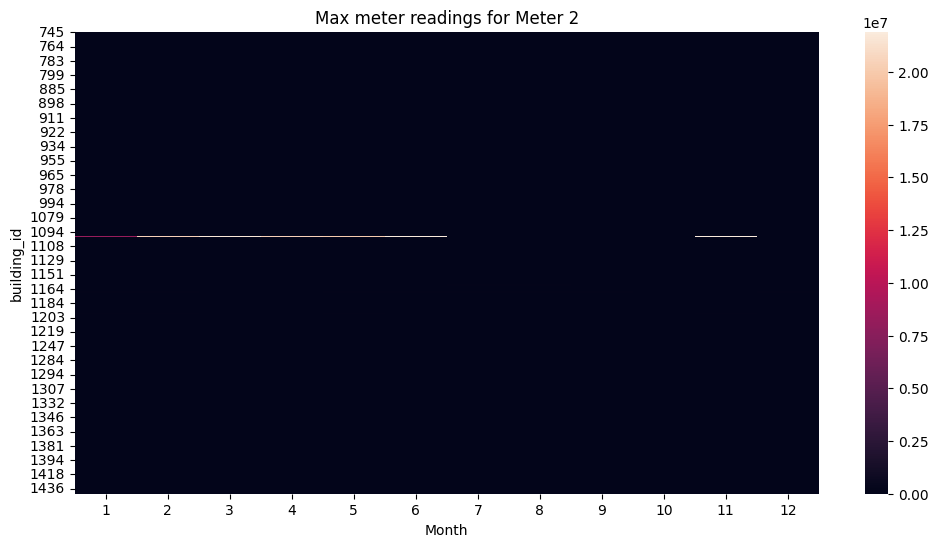

In [202]:
temp = train.copy()
temp["Month"] = temp["timestamp"].dt.month
temp = temp[temp["meter"]==2]
# temp["zero_meter_reading"] = (temp["meter_reading"] < 5).astype(int)
temp = temp.groupby(["building_id","Month"]).agg(max_readings = ("meter_reading", "max")).reset_index()

temp = pd.pivot_table(temp, values="max_readings", index=["building_id"], columns=["Month"], fill_value=0)
plt.figure(figsize = (12,6))
sns.heatmap(temp)
plt.title("Max meter readings for Meter 2")

del temp
gc.collect()

#### Clearly, the values for building 1099 are extremely high. Let's plot the mean meter reading for meter 2 (with building_id 1099)

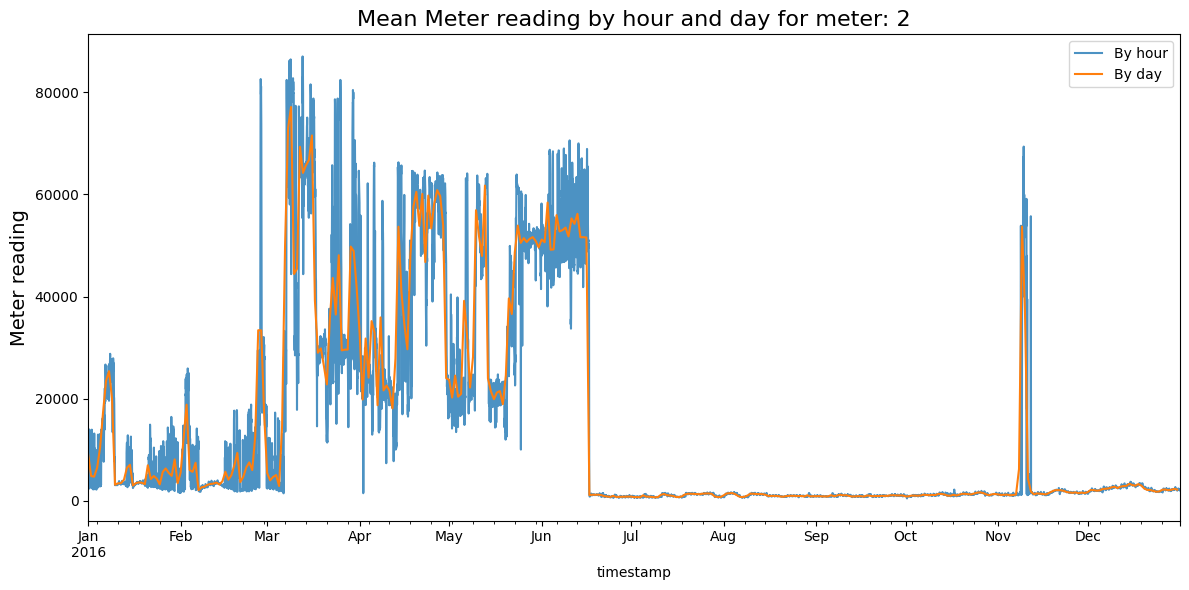

In [207]:
fig, axes = plt.subplots(1,1,figsize=(12, 6), dpi=100)

train[train['meter'] == 2][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[train['meter'] == 2][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day for meter: '+ str(i), fontsize=16);
axes.legend();
plt.tight_layout()

#### There seems to be big spikes, which are most probably driven by building 1099. Removing this and checking the trend

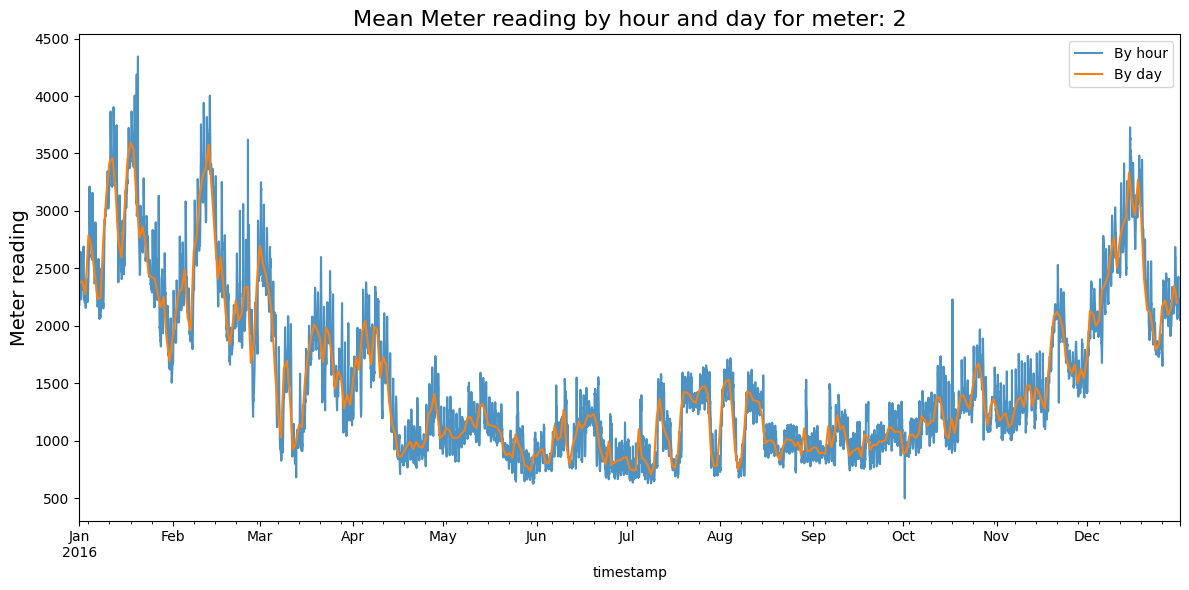

In [209]:
fig, axes = plt.subplots(1,1,figsize=(12, 6), dpi=100)

train[(train['meter'] == 2)&(train['building_id']!=1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[(train['meter'] == 2)&(train["building_id"]!=1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day for meter: '+ str(i), fontsize=16);
axes.legend();
plt.tight_layout()

#### Hence, it is clear that building 1099 is an outlier. Removing it for the analysis.

In [8]:
#Removing the outlier
train = train[train["building_id"]!=1099]

In [9]:
#Merge the 3 datasets to create a common ADF
train = train.merge(building, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

### Data Visualization

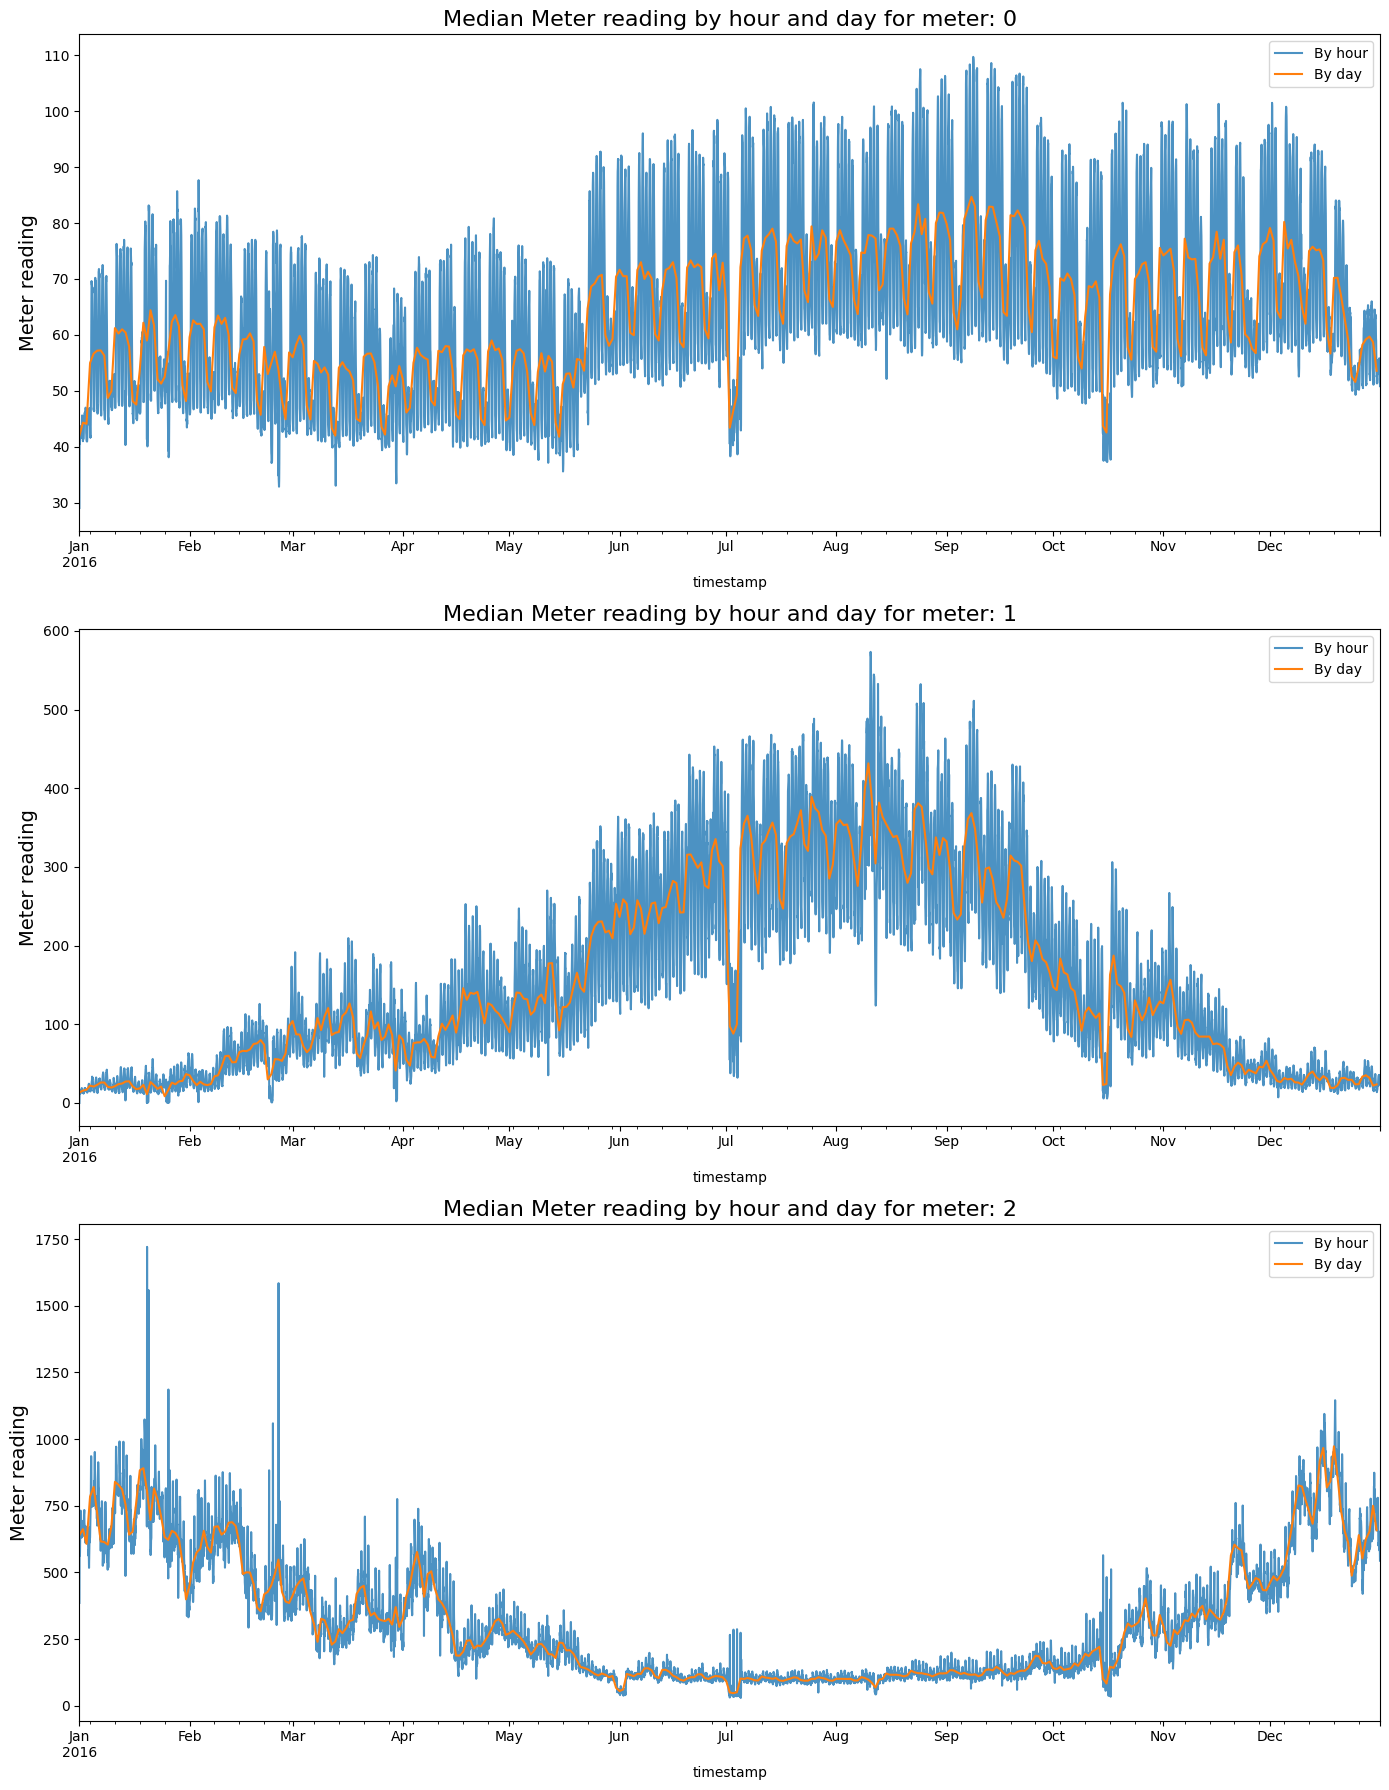

In [20]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in range(3):
    train[train['meter'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').median()['meter_reading'].plot(ax=axes[i], label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
    train[train['meter'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').median()['meter_reading'].plot(ax=axes[i], label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
    axes[i].set_title('Median Meter reading by hour and day for meter: '+ str(i), fontsize=16);
    axes[i].legend();
5plt.tight_layout()

/var/folders/6v/12r4qnjx54zgmfy66mv7j0rr0000gn/T/ipykernel_98182/1524494364.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr())


<AxesSubplot: >

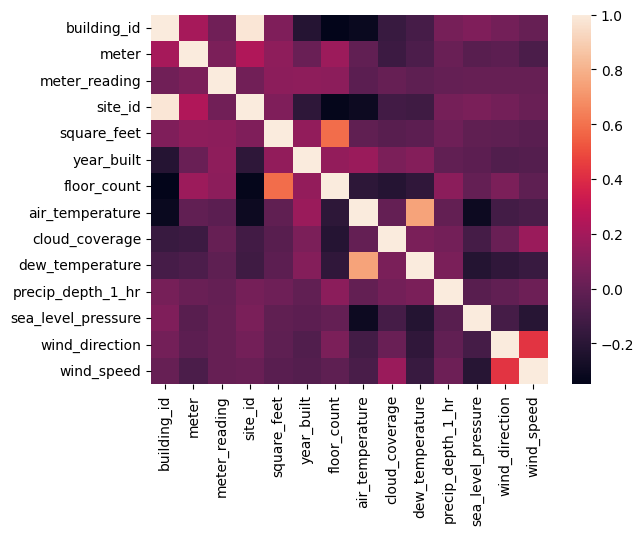

In [213]:
sns.heatmap(train.corr())

#### Check the boxplot of the meter readings for each meter (post outlier treatment)

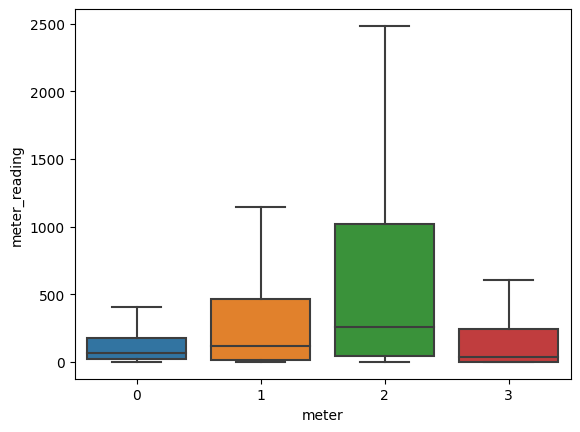

In [222]:
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

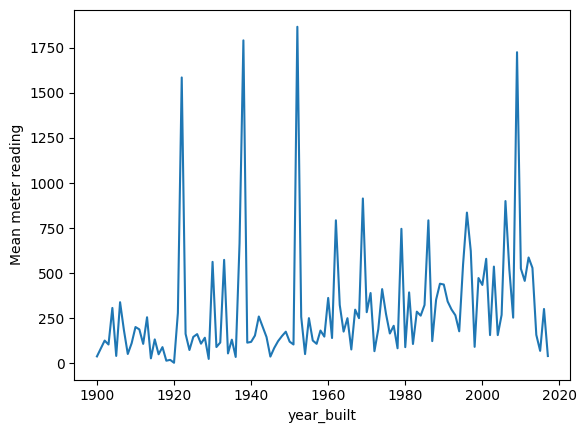

In [231]:
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');

<BarContainer object of 116 artists>

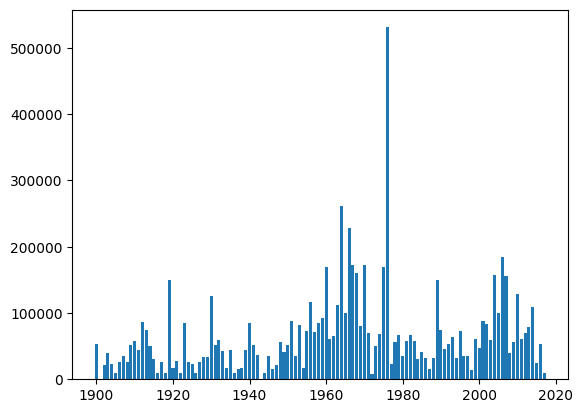

In [239]:
tmp = train.groupby('year_built').agg(c=("building_id", "count"))
plt.bar(tmp.index, tmp['c'])

#### With the year_built increasing there's an increase in the variance if mean_meter_reading, but no major correlation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


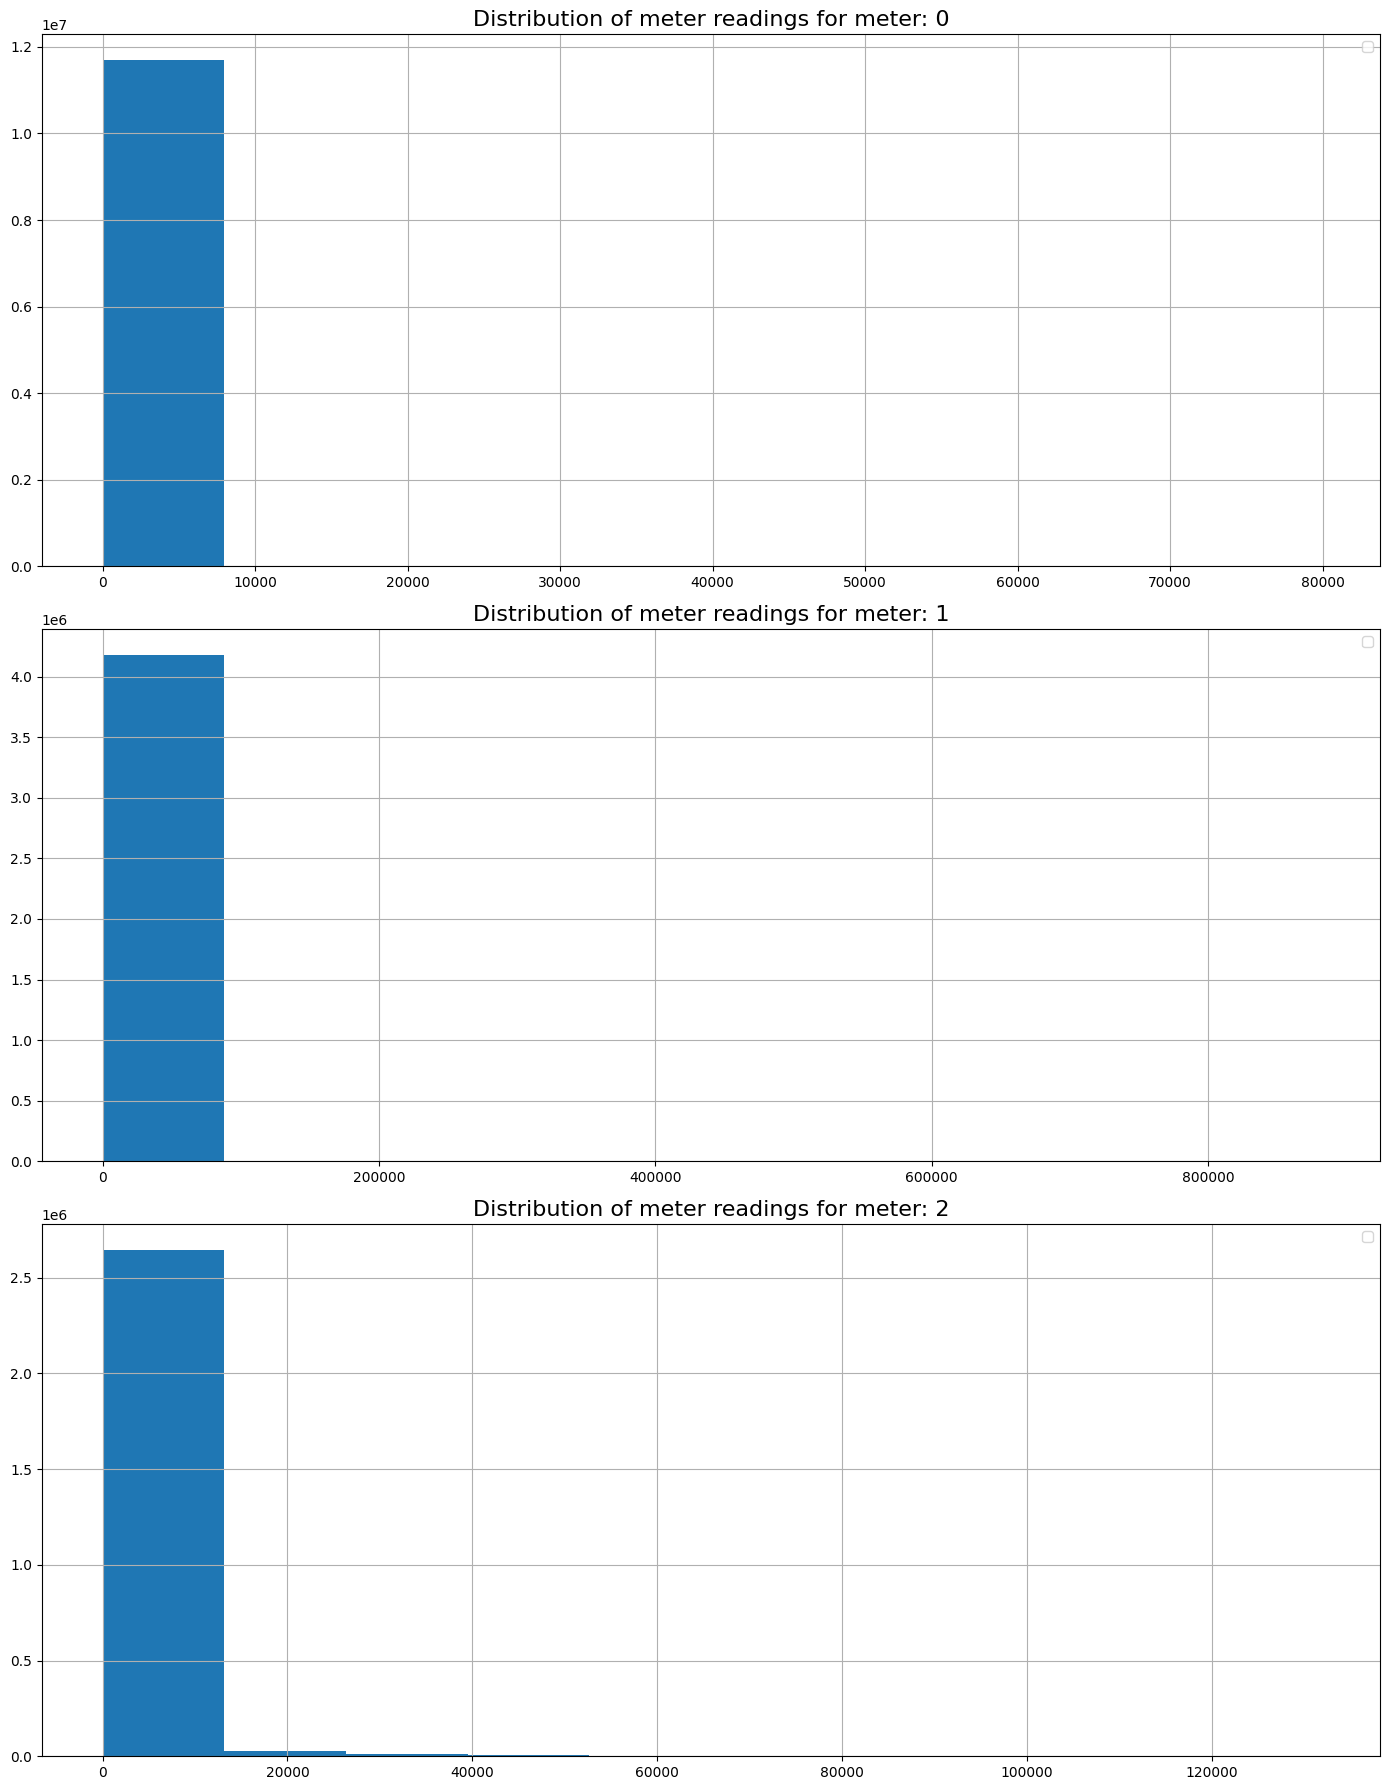

In [234]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in range(3):
    train[train['meter'] == i][['meter_reading']].hist(ax=axes[i])
    axes[i].set_title('Distribution of meter readings for meter: '+ str(i), fontsize=16);
    axes[i].legend();
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


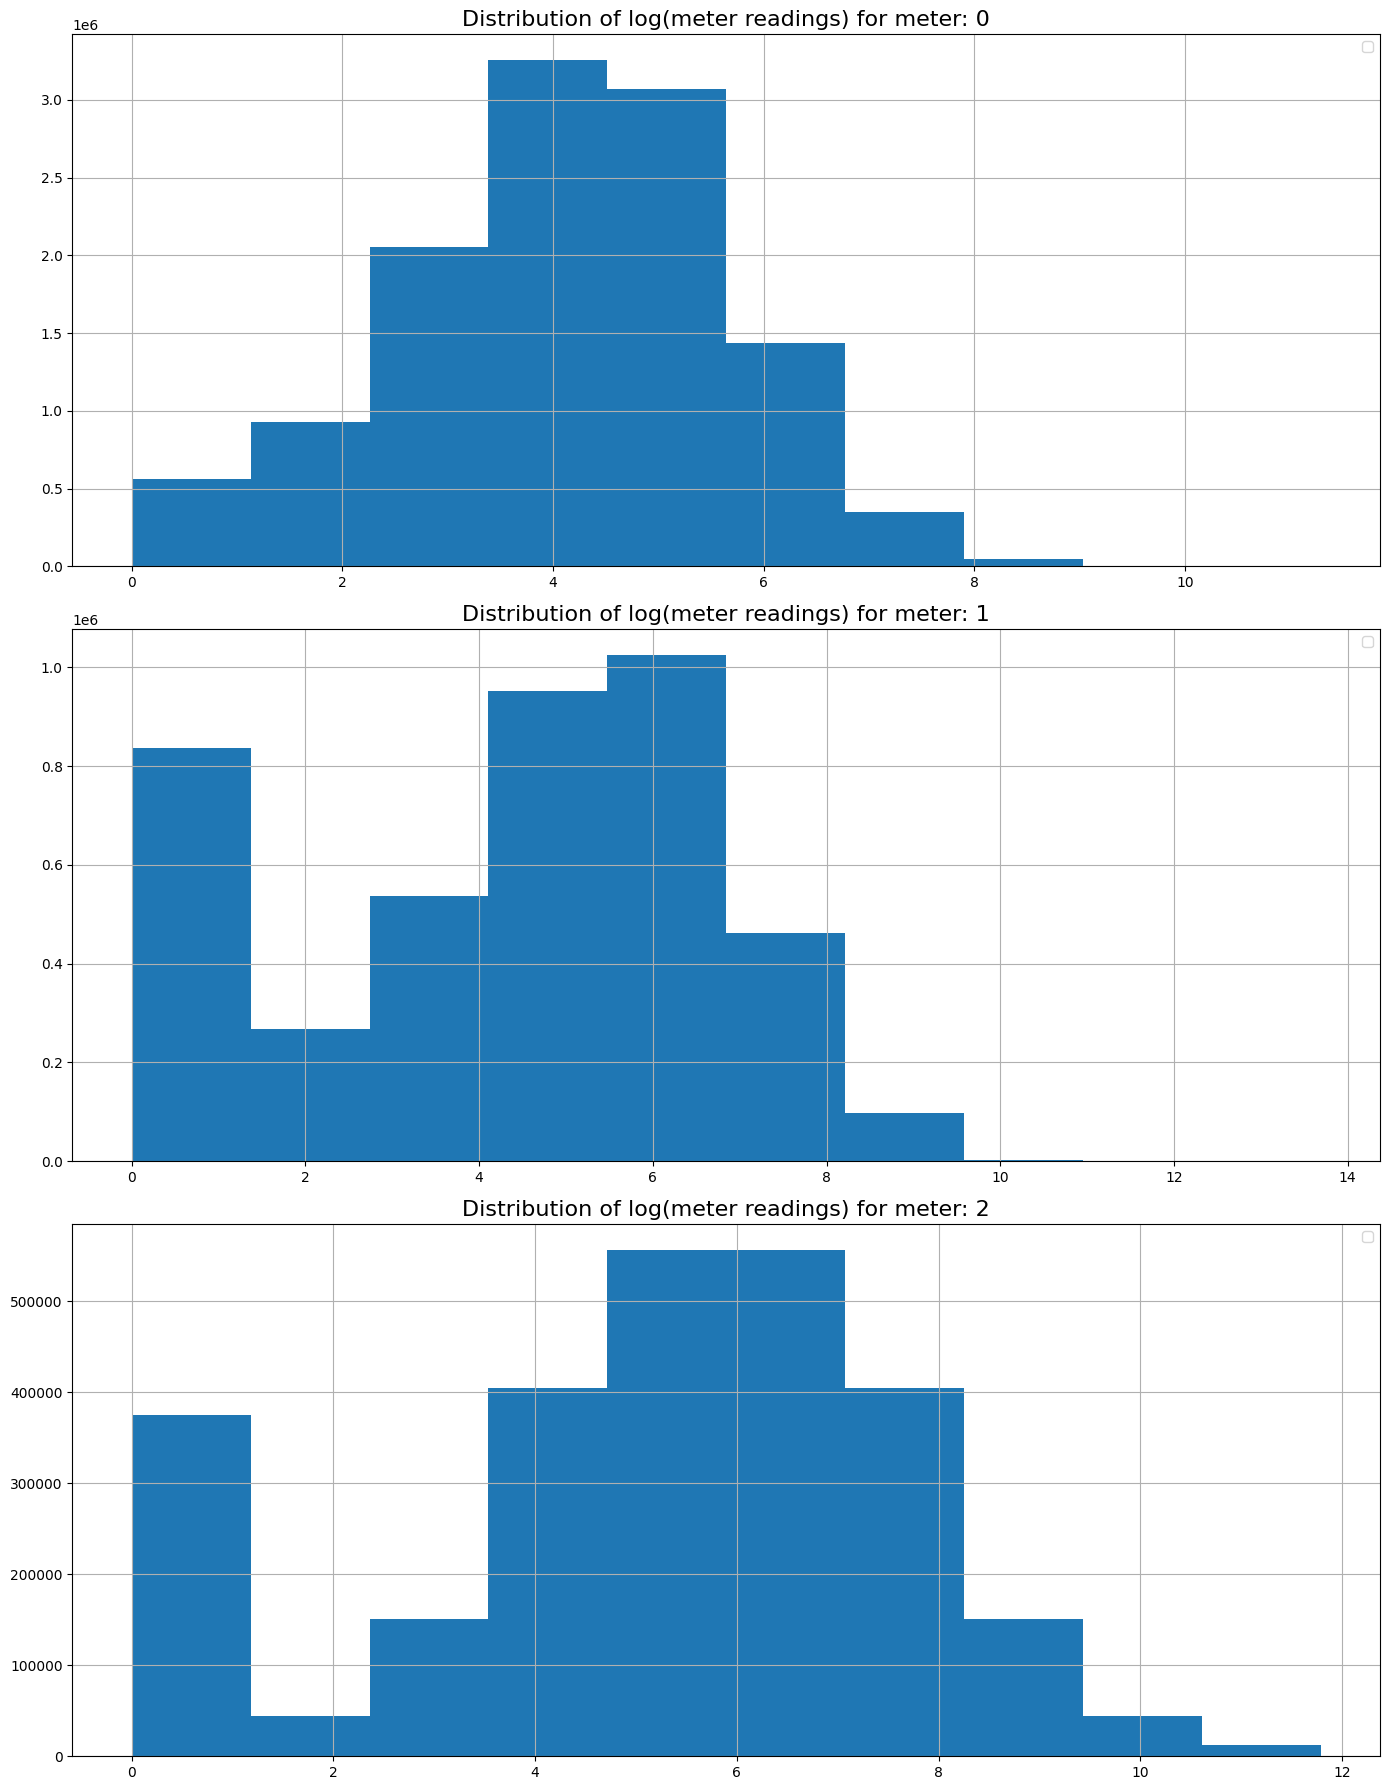

In [236]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in range(3):
    train[train['meter'] == i][['meter_reading']].apply(np.log1p).hist(ax=axes[i])
    axes[i].set_title('Distribution of log(meter readings) for meter: '+ str(i), fontsize=16);
    axes[i].legend();
plt.tight_layout()

#### Taking log of the target variable meter_reading is a good way to get a somewhat gaussian distribution

In [10]:
train["log_meter_reading"] = np.log1p(train["meter_reading"])

#### Feature Engineering

In [25]:
train['weekday'] = train['timestamp'].dt.weekday
train['hour'] = train['timestamp'].dt.hour
train['day'] = train['timestamp'].dt.day
train['weekend'] = train["timestamp"].dt.weekday.isin([5,6]).astype(int)
train['month'] = train['timestamp'].dt.month
train['log_square_feet'] =  np.log1p(train['square_feet'])

In [13]:
primary_use_enc = TargetEncoder(cols=["primary_use"]).fit(train["primary_use"], train["log_meter_reading"])
train["primary_use_enc"] = primary_use_enc.transform(train["primary_use"])

In [363]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use']
target='log_meter_reading'

In [335]:
X = train[features]
y = train[target]

#### Ridge Regression

In [374]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use']
target='log_meter_reading'

meters = train["meter"].sort_values().unique()
for idx,meter in enumerate(meters):
    X = train.loc[train["meter"] == meter,features].reset_index(drop=True)
    y = train.loc[train["meter"] == meter,target].reset_index(drop=True)
    tscv = TimeSeriesSplit()
    train_rmlse_scores, test_rmlse_scores = [], []
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test, y_train, y_test = X.loc[train_index,:].copy(), X.loc[test_index,:].copy(), y[train_index].copy(), y[test_index].copy()

        primary_use_enc = TargetEncoder(cols=["primary_use"]).fit(X_train["primary_use"], y_train)
        X_train["primary_use"] = primary_use_enc.transform(X_train["primary_use"])
        X_test["primary_use"] = primary_use_enc.transform(X_test["primary_use"])

        ridge_reg = Ridge(alpha=0.1)
        ridge_reg.fit(X_train, y_train)
        y_pred_train = ridge_reg.predict(X_train)
        train_rmlse_scores.append(mean_squared_error(y_train, y_pred_train, squared=False))
        y_pred_test = ridge_reg.predict(X_test)
        test_rmlse_scores.append(mean_squared_error(y_test, y_pred_test, squared=False))
        del X_train, X_test, y_train, y_test
        gc.collect()
    print("Meter %d: Avg Train RMSLE: %.4f, Avg Test RMSLE: %.4f" % (meter, np.mean(train_rmlse_scores), np.mean(test_rmlse_scores)))

Meter 0: Avg Train RMSLE: 1.1095, Avg Test RMSLE: 1.1466
Meter 1: Avg Train RMSLE: 2.1169, Avg Test RMSLE: 2.0881
Meter 2: Avg Train RMSLE: 2.1847, Avg Test RMSLE: 2.2977
Meter 3: Avg Train RMSLE: 2.1399, Avg Test RMSLE: 2.3545


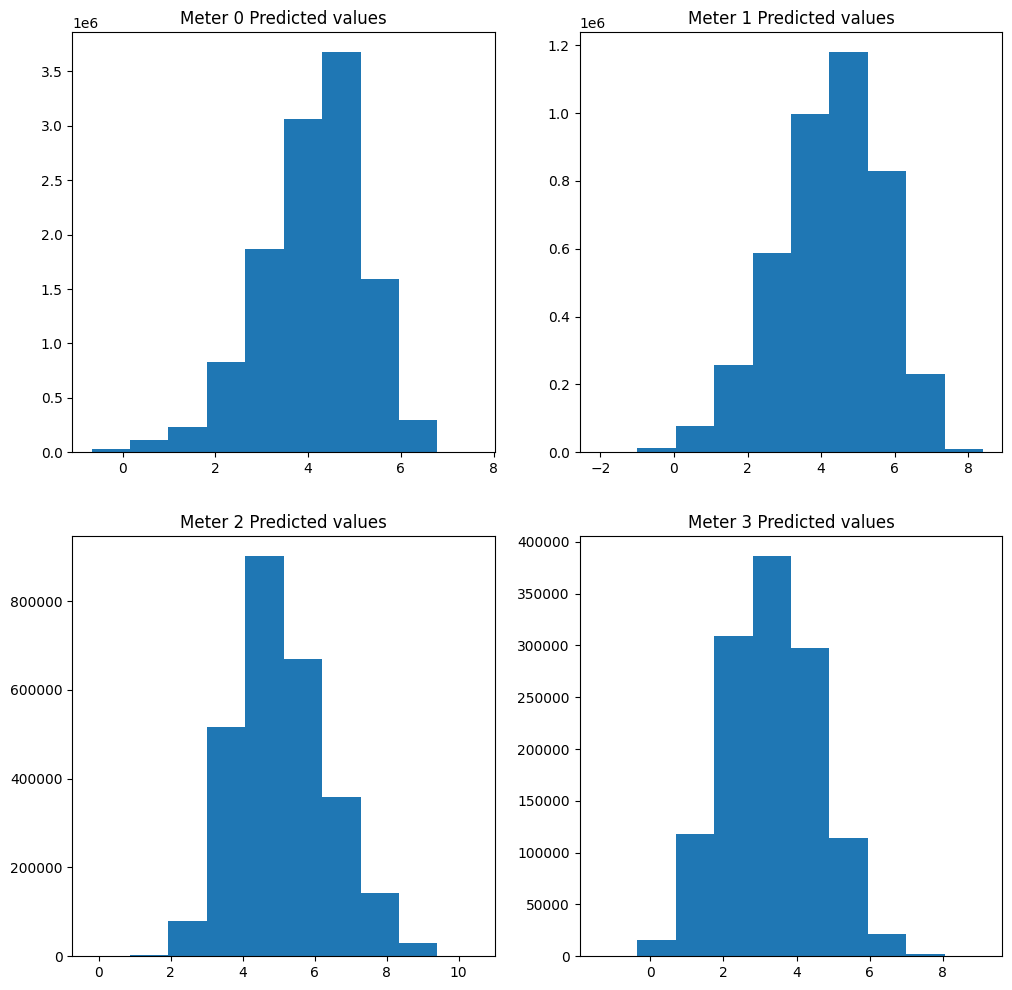

In [379]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use_enc', 'meter']

X = train[features]
y = train[target]

plt.figure(figsize=(12, 12))
for idx,meter in enumerate(meters):
    X = train.loc[train["meter"] == meter,features].reset_index(drop=True)
    y = train.loc[train["meter"] == meter,target].reset_index(drop=True)
    ridge_reg = Ridge(alpha=1)
    ridge_reg.fit(X, y)
    y_pred_train = ridge_reg.predict(X)
    plt.subplot(2,2,idx+1)
    plt.hist(y_pred_train)
    plt.title("Meter %d Predicted values" % (meter))

#### Lasso Regression

In [382]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use']
target='log_meter_reading'

meters = train["meter"].sort_values().unique()
for idx,meter in enumerate(meters):
    X = train.loc[train["meter"] == meter,features].reset_index(drop=True)
    y = train.loc[train["meter"] == meter,target].reset_index(drop=True)
    tscv = TimeSeriesSplit()
    train_rmlse_scores, test_rmlse_scores = [], []
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test, y_train, y_test = X.loc[train_index,:].copy(), X.loc[test_index,:].copy(), y[train_index].copy(), y[test_index].copy()

        primary_use_enc = TargetEncoder(cols=["primary_use"]).fit(X_train["primary_use"], y_train)
        X_train["primary_use"] = primary_use_enc.transform(X_train["primary_use"])
        X_test["primary_use"] = primary_use_enc.transform(X_test["primary_use"])

        lasso_reg = Lasso(alpha=0.01)
        lasso_reg.fit(X_train, y_train)
        y_pred_train = lasso_reg.predict(X_train)
        train_rmlse_scores.append(mean_squared_error(y_train, y_pred_train, squared=False))
        y_pred_test = lasso_reg.predict(X_test)
        test_rmlse_scores.append(mean_squared_error(y_test, y_pred_test, squared=False))
        del X_train, X_test, y_train, y_test
        gc.collect()
    print("Meter %d: Avg Train RMSLE: %.4f, Avg Test RMSLE: %.4f" % (meter, np.mean(train_rmlse_scores), np.mean(test_rmlse_scores)))

Meter 0: Avg Train RMSLE: 1.1102, Avg Test RMSLE: 1.1475
Meter 1: Avg Train RMSLE: 2.1173, Avg Test RMSLE: 2.0887
Meter 2: Avg Train RMSLE: 2.1852, Avg Test RMSLE: 2.2983
Meter 3: Avg Train RMSLE: 2.1402, Avg Test RMSLE: 2.3537


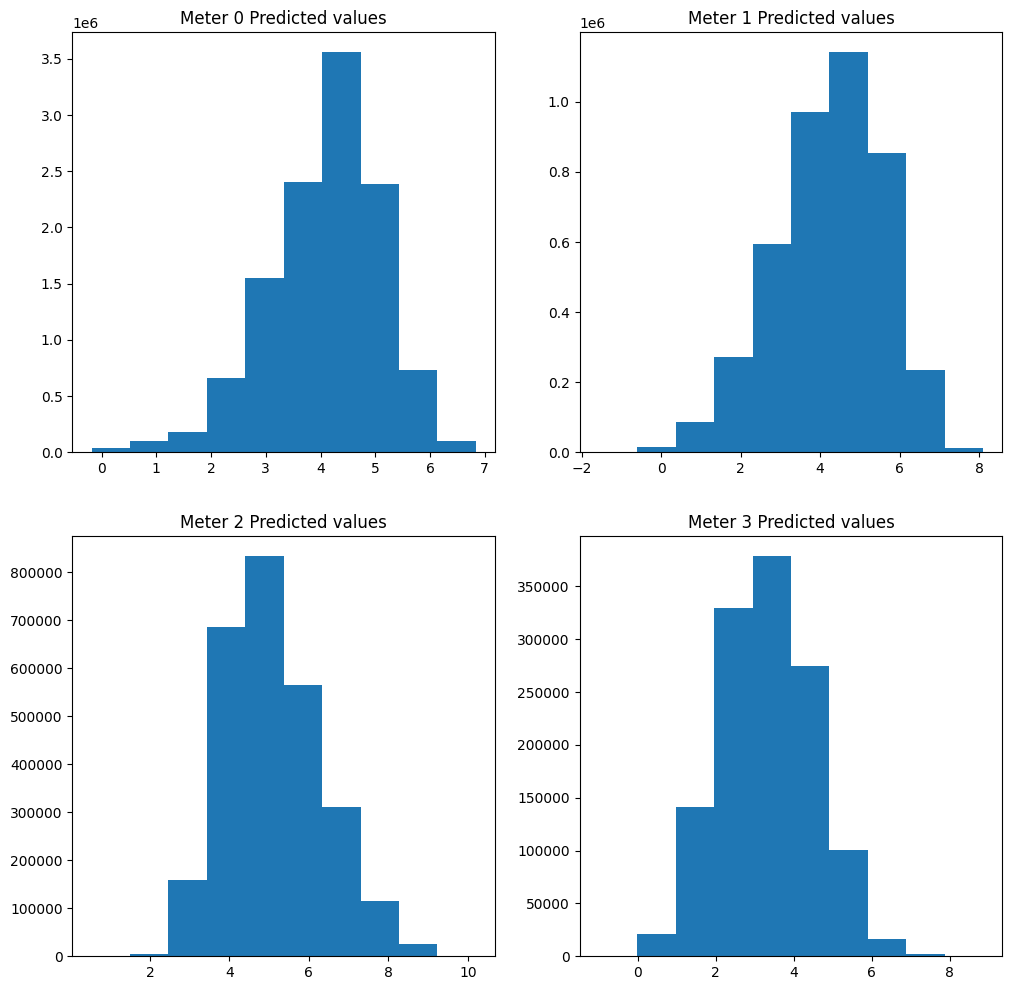

In [383]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use_enc', 'meter']

X = train[features]
y = train[target]

plt.figure(figsize=(12, 12))
for idx,meter in enumerate(meters):
    X = train.loc[train["meter"] == meter,features].reset_index(drop=True)
    y = train.loc[train["meter"] == meter,target].reset_index(drop=True)
    lasso_reg = Lasso(alpha=0.1)
    lasso_reg.fit(X, y)
    y_pred_train = lasso_reg.predict(X)
    plt.subplot(2,2,idx+1)
    plt.hist(y_pred_train)
    plt.title("Meter %d Predicted values" % (meter))

#### Kernel Ridge (Trial)

In [ ]:
features=['air_temperature', 'cloud_coverage', 'dew_temperature',\
          'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',\
          'wind_speed', 'weekday', 'hour', 'weekend',\
          'log_square_feet', 'primary_use']
target='log_meter_reading'

meters = train["meter"].sort_values().unique()
for idx,meter in enumerate(meters):
    X = train.loc[train["meter"] == meter,features].reset_index(drop=True)
    y = train.loc[train["meter"] == meter,target].reset_index(drop=True)
    tscv = TimeSeriesSplit()
    train_rmlse_scores, test_rmlse_scores = [], []
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test, y_train, y_test = X.loc[train_index,:].copy(), X.loc[test_index,:].copy(), y[train_index].copy(), y[test_index].copy()

        primary_use_enc = TargetEncoder(cols=["primary_use"]).fit(X_train["primary_use"], y_train)
        X_train["primary_use"] = primary_use_enc.transform(X_train["primary_use"])
        X_test["primary_use"] = primary_use_enc.transform(X_test["primary_use"])

        ridge_reg = KernelRidge(alpha=0.01, kernel='polynomial', degree=2)
        ridge_reg.fit(X_train, y_train)
        y_pred_train = ridge_reg.predict(X_train)
        train_rmlse_scores.append(mean_squared_error(y_train, y_pred_train, squared=False))
        y_pred_test = ridge_reg.predict(X_test)
        test_rmlse_scores.append(mean_squared_error(y_test, y_pred_test, squared=False))
        del X_train, X_test, y_train, y_test
        gc.collect()
    print("Meter %d: Avg Train RMSLE: %.4f, Avg Test RMSLE: %.4f" % (meter, np.mean(train_rmlse_scores), np.mean(test_rmlse_scores)))

In [143]:
# This is the Kaggle Test Set (We don't have target variable for this)
# Same treatment with Testset 
# test["timestamp"] = pd.to_datetime(test["timestamp"])
# test = reduce_mem_usage(test)
# test = test[test["building_id"]!=1099]

# weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"])
# weather_test = weather_data_parser(weather_test)
# weather_test = reduce_mem_usage(weather_test)

# test = test.merge(building, on='building_id', how='left')
# test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
# test['weekday'] = test['timestamp'].dt.weekday
# test['month'] = test['timestamp'].dt.month
# test['hour'] = test['timestamp'].dt.hour
# test['weekend'] = test["timestamp"].dt.weekday.isin([5,6]).astype(int)
# test['log_square_feet'] =  np.log1p(test['square_feet'])
# test["primary_use_enc"] = primary_use_enc.transform(test["primary_use"])

#### Train-Test Split (Randomized with Constraint - (building_id, meter) should non-overlapping across test/train )

In [134]:
TEST_SIZE = 0.3
building_meter_df = train.groupby(["building_id", "meter"])\
                        .agg(avg_meter_reading=("log_meter_reading", np.mean))\
                        .drop("avg_meter_reading", axis=1).reset_index()
building_meter_train_df, building_meter_test_df = train_test_split(building_meter_df, test_size=TEST_SIZE, random_state=5)

#### Checking the distribution of meters

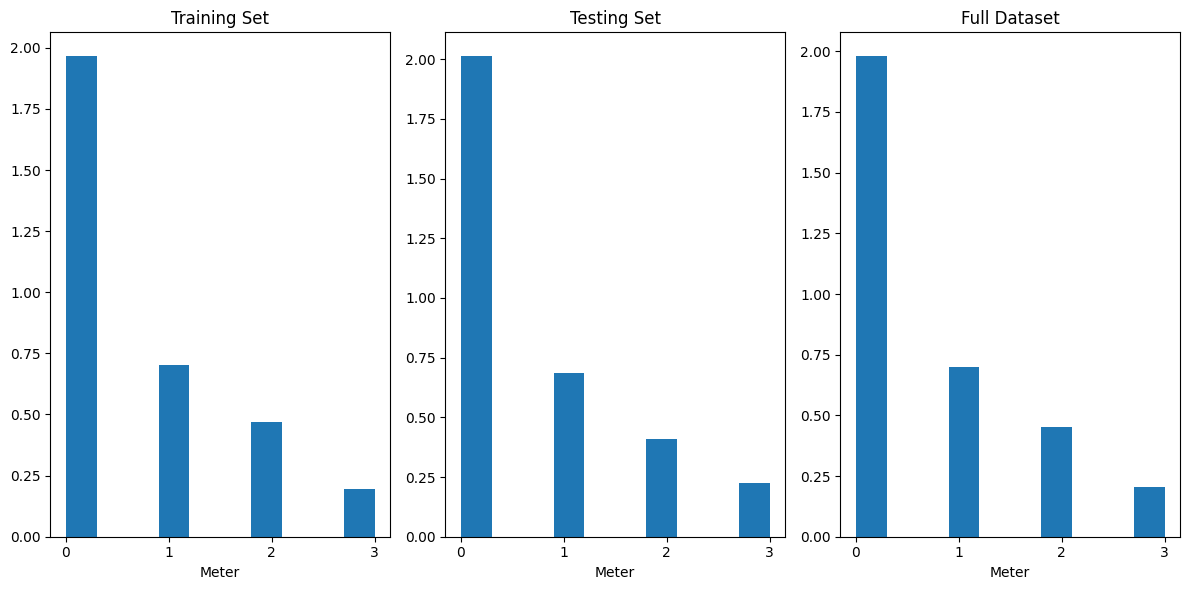

In [135]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.hist(building_meter_train_df["meter"].sort_values().astype(str), density=True)
plt.title("Training Set")
plt.xlabel("Meter")
plt.subplot(1,3,2)
plt.hist(building_meter_test_df["meter"].sort_values().astype(str), density=True)
plt.title("Testing Set")
plt.xlabel("Meter")
plt.subplot(1,3,3)
plt.hist(building_meter_df["meter"].sort_values().astype(str), density=True)
plt.title("Full Dataset")
plt.xlabel("Meter")
plt.tight_layout()

#### Merging the train-test split to get the train-test dataset 

In [136]:
train_df = train.merge(building_meter_train_df, on=["building_id","meter"], how="inner")
test_df = train.merge(building_meter_test_df, on=["building_id","meter"], how="inner")

In [137]:
train_building_id = train_df[train_df["meter"]==2]["building_id"].unique()
test_building_id = test_df[test_df["meter"]==2]["building_id"].unique()
set(train_building_id).intersection(set(test_building_id))

set()

#### Checking the distribution of target variable across train and test dataset

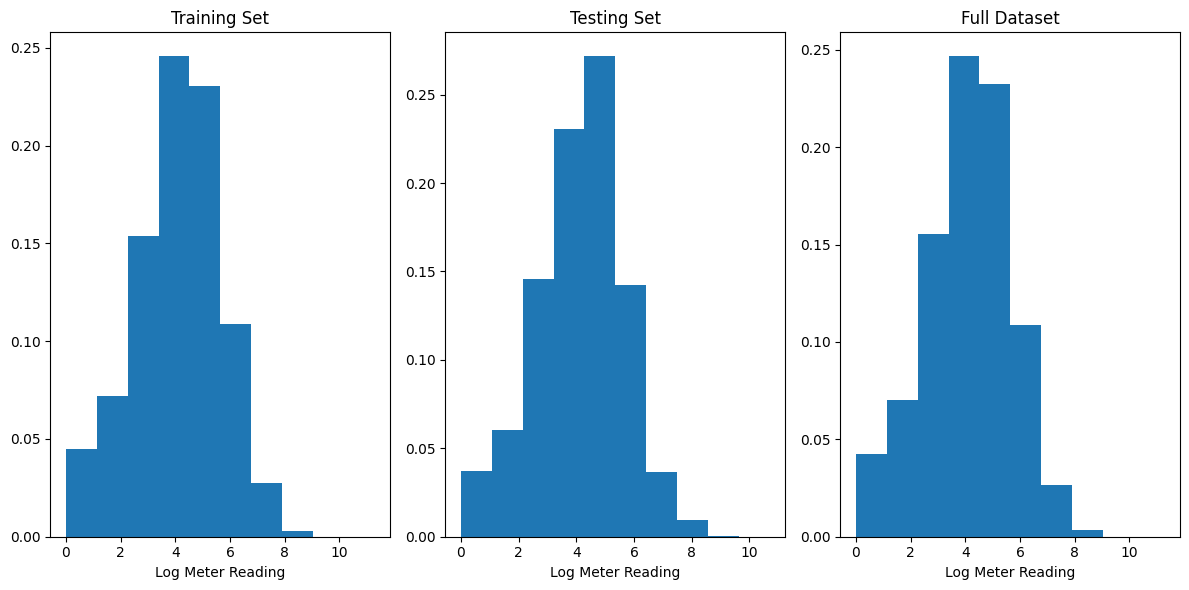

In [138]:
meter_id = 0

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.hist(train_df[train_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Training Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,2)
plt.hist(test_df[test_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Testing Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,3)
plt.hist(train[train["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Full Dataset")
plt.xlabel("Log Meter Reading")
plt.tight_layout()

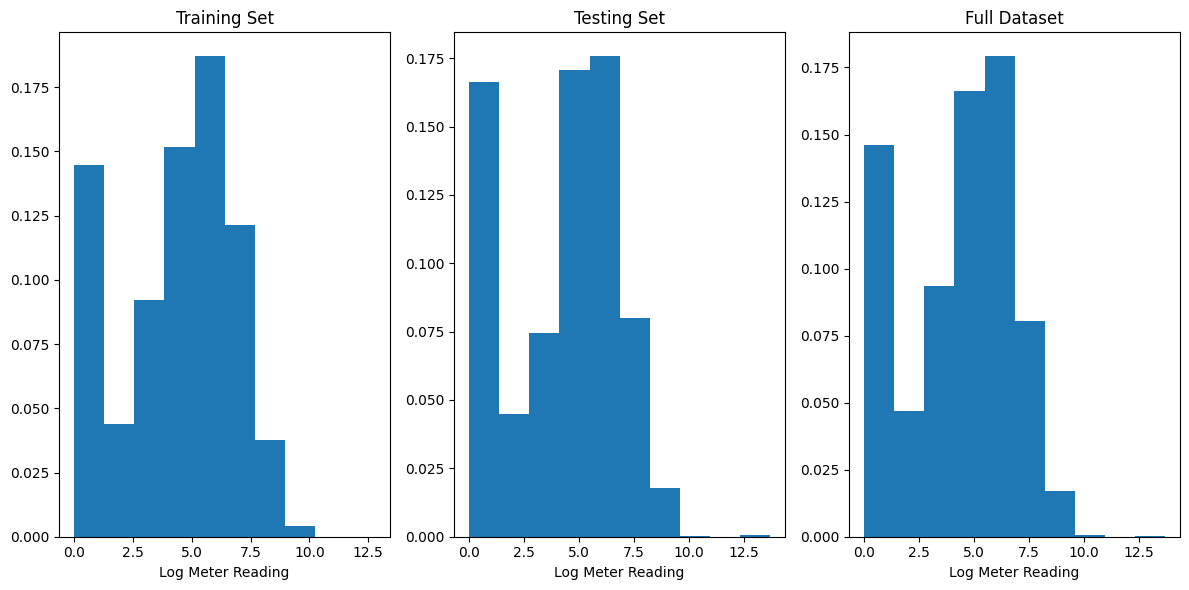

In [141]:
meter_id = 1

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.hist(train_df[train_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Training Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,2)
plt.hist(test_df[test_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Testing Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,3)
plt.hist(train[train["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Full Dataset")
plt.xlabel("Log Meter Reading")
plt.tight_layout()

#### Using SKLearn StratifiedGroupKFold

In [146]:
discretized_target = np.digitize(train["log_meter_reading"], bins = np.linspace(0, train["log_meter_reading"].max(), 30))


In [161]:
sgkf = StratifiedGroupKFold(n_splits=4)
sgkf_gen = sgkf.split(train, discretized_target, train["building_id"].astype(str) + "_" + train["meter"].astype(str))

In [162]:
train_index, test_index = next(sgkf_gen)

/Users/sharaddargan/Documents/env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [154]:
train_sk_df = train.loc[train_index,:]
test_sk_df = train.loc[test_index,:]

In [156]:
train_building_id = train_sk_df[train_sk_df["meter"]==2]["building_id"].unique()
test_building_id = test_sk_df[test_sk_df["meter"]==2]["building_id"].unique()
set(train_building_id).intersection(set(test_building_id))

set()

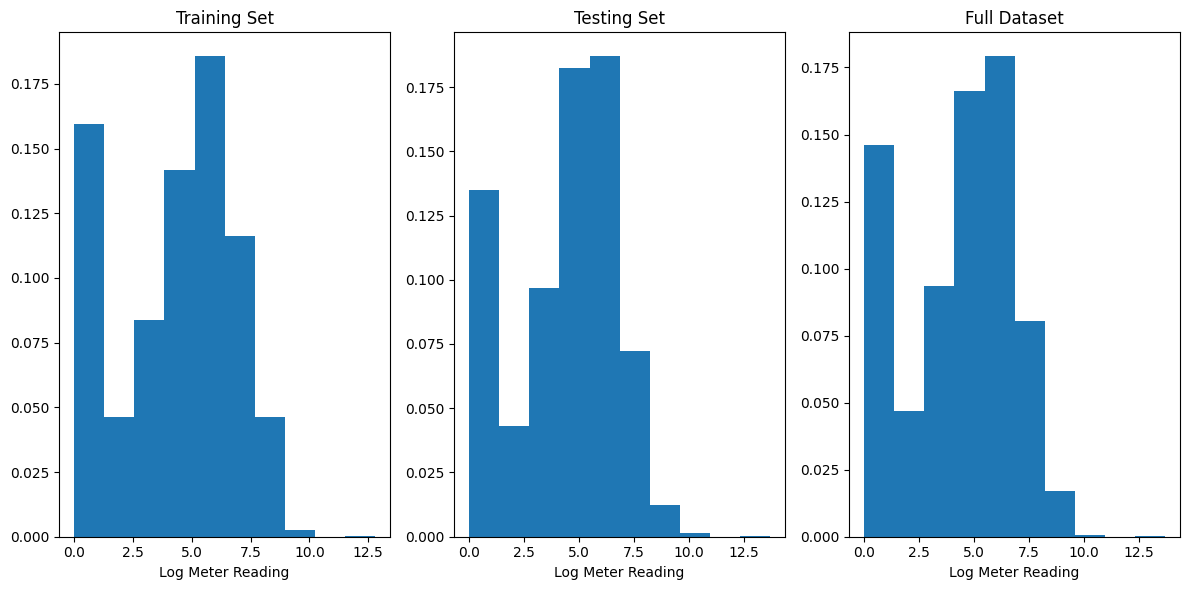

In [160]:
meter_id = 1

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.hist(train_sk_df[train_sk_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Training Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,2)
plt.hist(test_sk_df[test_sk_df["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Testing Set")
plt.xlabel("Log Meter Reading")
plt.subplot(1,3,3)
plt.hist(train[train["meter"]==meter_id]["log_meter_reading"], density=True)
plt.title("Full Dataset")
plt.xlabel("Log Meter Reading")
plt.tight_layout()